In [1]:
import pyautogui
import pytesseract

import re
from tsapi.utils import save_as_yaml, read_yaml_file
from tqdm import tqdm
from IPython.display import clear_output

/Users/my/Documents/anaconda/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
pyautogui.position()

In [59]:
pyautogui.position().x

1074

In [13]:
pyautogui.position()

Point(x=721, y=247)

In [19]:
pyautogui.position()

Point(x=1812, y=342)

In [20]:
_y0 = 185
_y1 = 209
_ohlcv_region = (57, _y0, 497-57, _y1-_y0)
_o_region = (57, _y0, 123-57, _y1-_y0)
_h_region = (122, _y0, 181-122, _y1-_y0)
_l_region = (181, _y0, 239-181, _y1-_y0)
_c_region = (238, _y0, 390-238, _y1-_y0)
_v_region = (390, _y0, 497-390, _y1-_y0)

xregion = {
    'O': _o_region,
    'H': _h_region,
    'L': _l_region,
    'C': _c_region,
    'V': _v_region
}
_mouse_location_consty = 447
_mouse_location_x = 1812
_tick_gap = 18
_collect_steps = 15
_tgt_tick_num = int(20*7*24*60/5)
_tgt_tick_num, _tgt_tick_num/_collect_steps

(40320, 2688.0)

In [25]:
pyautogui.click(x=_mouse_location_x, y=_mouse_location_consty)
x = _mouse_location_x
pyautogui.moveTo(x=x, y=_mouse_location_consty, duration=2)
global_id = 28562
ohlcv_save_file = "/Users/my/Library/Mobile Documents/com~apple~CloudDocs/env/projects/us_intraday/QQQ/ohlcv5min.yaml"
roundx = 0
xregion = {
    'O': _o_region,
    'H': _h_region,
    'L': _l_region,
    'C': _c_region,
    'V': _v_region
}

_collected = {}

while(global_id < _tgt_tick_num):
    print("Round: ", roundx, "Ticks Collected: ", len(_collected))
    roundx+=1
    
    pyautogui.click(x=_mouse_location_x, y=_mouse_location_consty)
    x = _mouse_location_x
    pyautogui.moveTo(x=x, y=_mouse_location_consty, duration=1)

    _collected = {}
    for i in tqdm(range(_collect_steps)):
        x-=_tick_gap
        pyautogui.moveTo(x=x, y=_mouse_location_consty, duration=1)
        
        ohlcv = []
        for _p, _rg in xregion.items():                
            _fig = pyautogui.screenshot(region=_rg)
            _str = pytesseract.image_to_string(_fig)
            if _p=='V':
                vol = [x.replace(",", "") for x in re.findall(" ([0-9,]+)", _str)]
            else:
                try:
                    _num = re.findall("([0-9]{3}[.][0-9]{1,2})", _str)[0].replace(" ", "")
                except:
                    _num = ''
                ohlcv.append(_p+_num)
        
        _collected.update({global_id: ",".join(ohlcv + vol)})
        global_id+=1
        
    if global_id>_collect_steps:
        _histdict = read_yaml_file(ohlcv_save_file)
        _histdict.update(_collected)
        _collected = _histdict.copy()
    save_as_yaml(ohlcv_save_file, _collected)

    current_pos = pyautogui.position()
    pyautogui.click(current_pos)
    pyautogui.mouseDown(current_pos, button='left')
    pyautogui.dragTo(_mouse_location_x, _mouse_location_consty, button='left')
    
    clear_output(wait=True)

Round:  1904 Ticks Collected:  28560


 13%|█████▊                                      | 2/15 [00:05<00:35,  2.73s/it]


FailSafeException: PyAutoGUI fail-safe triggered from mouse moving to a corner of the screen. To disable this fail-safe, set pyautogui.FAILSAFE to False. DISABLING FAIL-SAFE IS NOT RECOMMENDED.

In [112]:
global_id

28562

In [26]:
ohlcvcollected = read_yaml_file(ohlcv_save_file)

In [27]:
len(ohlcvcollected)

28560

In [28]:
type(ohlcvcollected)

dict

In [50]:
import numpy as np
import pandas as pd

ohlcvlist = []
for k, xlist in ohlcvcollected.items():
    xlist = xlist.split(",")
    if len(xlist)==5:
        o, h, l, c, v = xlist
        ohlcvlist.append([o, h, l, c, v])
    elif len(xlist)==4:
        ohlcvlist.append(xlist + [np.nan])
    elif len(xlist)==6:
        ohlcvlist.append(xlist[:4] + [np.nan])

In [76]:
ohlcvpd = pd.DataFrame(ohlcvlist[:])

In [77]:
def transform_ohlc(x):
    x = x.replace('O', '').replace('H', '').replace('L', '').replace('C', '').replace(' ', '')
    if len(x)==0:
        return np.nan
    else:
        return float(x)
    
for c in [0, 1, 2, 3]:
    ohlcvpd[c] = ohlcvpd[c].apply(lambda x: transform_ohlc(x))

In [78]:
def transform_vol(x):
    try:
        x = x.replace(' ', '')
        return float(x)
    except:
        return np.nan

ohlcvpd[4] = ohlcvpd[4].apply(lambda x: transform_vol(x))

In [79]:
for c in [0, 1, 2, 3, 4]:
    print(ohlcvpd[c].isna().sum() / len(ohlcvpd))

0.07643557422969188
0.054411764705882354
0.032457983193277314
0.03634453781512605
0.031057422969187676


In [80]:
ohlcvpd[3] = ohlcvpd[3].fillna(ohlcvpd[0].shift(-1))
ohlcvpd[0] = ohlcvpd[0].fillna(ohlcvpd[3].shift())

In [85]:
ohlcvpdranked = ohlcvpd.sort_index(ascending=False)
ohlcvpdranked.index = range(len(ohlcvpdranked))
ohlcvpdranked.columns = ['O', 'H', 'L', 'C', 'V']

In [97]:
for c in ohlcvpdranked.columns:
    print(ohlcvpdranked[c].isna().sum() / len(ohlcvpdranked))

0.00311624649859944
0.054411764705882354
0.032457983193277314
0.00311624649859944
0.031057422969187676
0.9536064425770309
0.9536064425770309
0.9536064425770309


In [98]:
ohlcvpdranked['C'] = ohlcvpdranked['C'].ffill()

In [99]:
from tsapi.tools.us_intraday import add_macd_elements_topd_paras

ohlcvpdranked = add_macd_elements_topd_paras(ohlcvpdranked, pxcol='C', fastperiod=12, slowperiod=26, signalperiod=9)

In [100]:
ohlcvpdranked.columns

Index(['O', 'H', 'L', 'C', 'V', 'C_macd_12_26_9', 'C_macd_signal_12_26_9',
       'C_macd_hist_12_26_9'],
      dtype='object')

In [105]:
ohlcvpdranked['C_macd_12_26_9'].dropna().max()

9.225450552181599

In [106]:
ohlcvpdranked['C_macd_12_26_9'].dropna().min()

-5.385359194004934

In [108]:
ohlcvpdranked['C_macd_12_26_9'].dropna().mean()

0.00681109448067223

<Axes: >

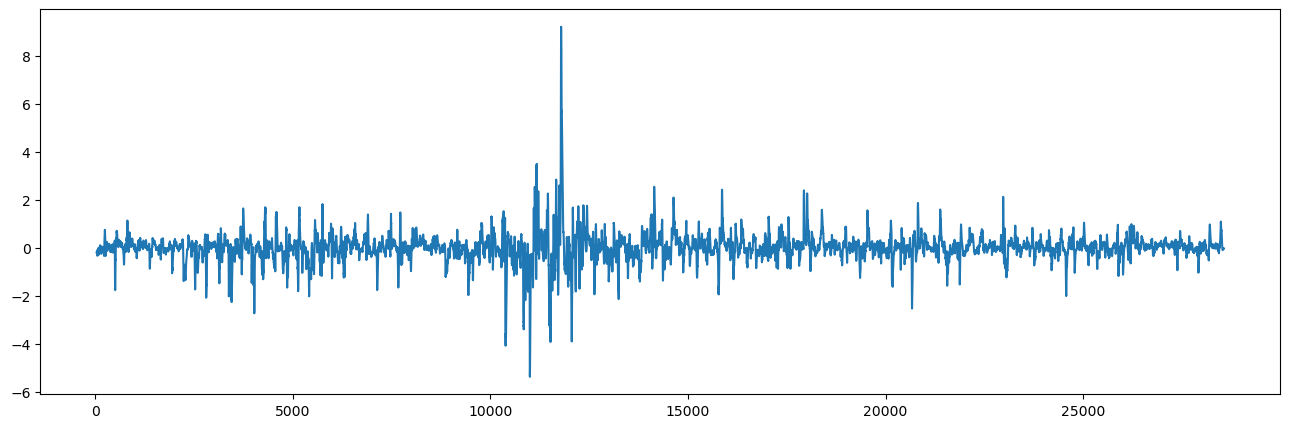

In [111]:
ohlcvpdranked['C_macd_12_26_9'].dropna().plot(figsize=(16, 5))

In [113]:
ohlcvpdranked

,O,H,L,C,V,C_macd_12_26_9,C_macd_signal_12_26_9,C_macd_hist_12_26_9
0,528.58,528.58,528.08,528.28,140585.0,NaN,NaN,NaN
1,528.30,528.39,528.24,528.38,91102.0,NaN,NaN,NaN
2,528.34,528.62,528.35,528.51,127840.0,NaN,NaN,NaN
3,528.53,528.58,528.28,528.34,93172.0,NaN,NaN,NaN
4,528.40,528.68,528.33,528.52,118001.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
28555,555.78,555.81,555.73,555.75,816.0,-0.026863,-0.023967,-0.002896
28556,555.77,555.80,555.75,555.76,499.0,-0.029145,-0.025003,-0.004142
28557,555.79,555.79,555.71,555.75,1617.0,-0.031398,-0.026282,-0.005116
28558,555.78,555.79,555.69,555.78,23080.0,-0.030412,-0.027108,-0.003305


In [102]:
ohlcvpdranked

,O,H,L,C,V,C_macd_12_26_9,C_macd_signal_12_26_9,C_macd_hist_12_26_9
0,528.58,528.58,528.08,528.28,140585.0,NaN,NaN,NaN
1,528.30,528.39,528.24,528.38,91102.0,NaN,NaN,NaN
2,528.34,528.62,528.35,528.51,127840.0,NaN,NaN,NaN
3,528.53,528.58,528.28,528.34,93172.0,NaN,NaN,NaN
4,528.40,528.68,528.33,528.52,118001.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
28555,555.78,555.81,555.73,555.75,816.0,-0.026863,-0.023967,-0.002896
28556,555.77,555.80,555.75,555.76,499.0,-0.029145,-0.025003,-0.004142
28557,555.79,555.79,555.71,555.75,1617.0,-0.031398,-0.026282,-0.005116
28558,555.78,555.79,555.69,555.78,23080.0,-0.030412,-0.027108,-0.003305


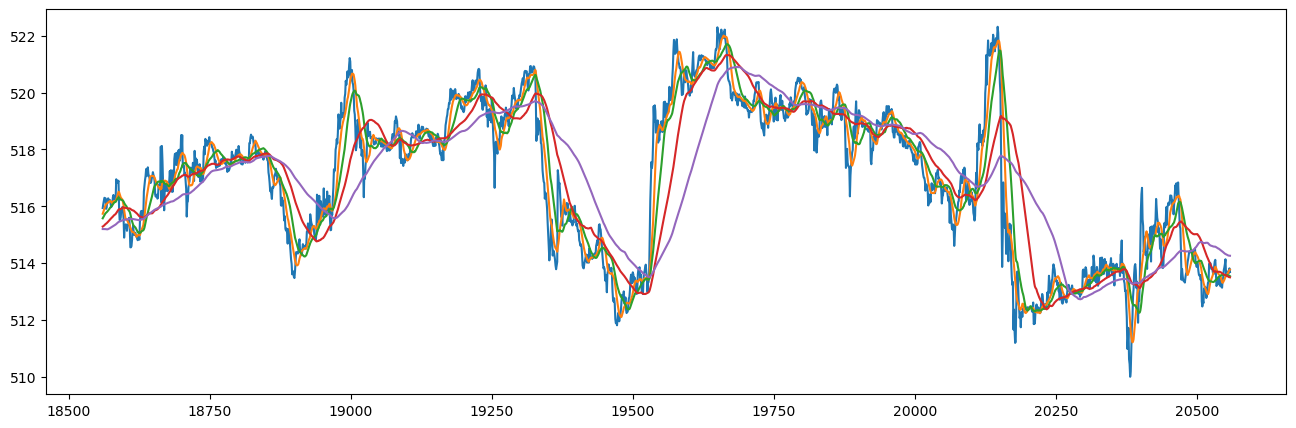

In [125]:
import matplotlib.pyplot as plt

x1, x2 = -10000, -8000

ohlcvpdranked['C'].iloc[x1:x2].plot(figsize=(16, 5))
plt.plot(ohlcvpdranked['C'].rolling(12).mean().iloc[x1:x2])
plt.plot(ohlcvpdranked['C'].rolling(26).mean().iloc[x1:x2])
plt.plot(ohlcvpdranked['C'].rolling(60).mean().iloc[x1:x2])
plt.plot(ohlcvpdranked['C'].rolling(120).mean().iloc[x1:x2])

In [ ]:
ohlcvpdranked['']

In [66]:
pyautogui.moveTo(x=_mouse_location_x, y=_mouse_location_consty)

In [ ]:
pyautogui.screenshot(region=_ohlcv_region)

In [56]:
_collected = _histdict.copy()

In [53]:
_collected = {0: ",".join(ohlcv + vol)}
_histdict = read_yaml_file(ohlcv_save_file)
_histdict.update(_collected)

In [54]:
_histdict

{19: '555.79,555.80,555.77,555.79,3,229',
 20: '555.79,555.80,555.77,555.79,3,229',
 0: '555.79,555.80,555.77,555.79,3,229'}

In [ ]:
pyautogui.click(_base_point)
pyautogui.mouseDown(_base_point, button='left')
pyautogui.dragTo(_base_point[0]+_tick_gap, _base_point[1], button='left')

In [12]:
ohlcvfig = pyautogui.screenshot(region=_ohlcv_region)

In [13]:
ohlcvfig

In [29]:
figstr = pytesseract.image_to_string(ohlcvfig)

O, H, L, C = re.findall("([0-9]{3}[.][0-9]{,2})", figstr)
Vol = re.findall("Vol ([0-9,]+)", figstr)

['8,009']